In [1]:
import matplotlib.pyplot as plt
# Imports to enable scaled vector graphics
# %matplotlib notebook
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
from pvibrations import SDOFOscillator



The physics of a single degree of freedom system is defined in the class *SDOFOscillator*. Both analytical and numerial solutions to the dynamic equation are defined. It will provide a data source from which a machine learning model will be trained

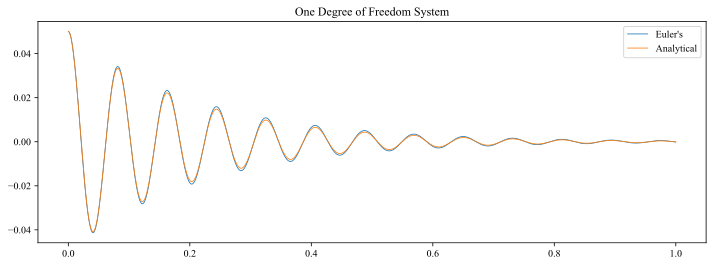

In [3]:
tstep = 0.0001 # Adjust this variable to improve Euler's Method

# m=4, c=30, k=2000
physics = SDOFOscillator(m=5, c=50, k=30000, h=tstep, time_duration=1)
physics.compute_analytical()
physics.compute_euler()
physics.plot_values()


In [4]:
import numpy as np
import tensorflow as tf

class DataOscillatorModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        self.layer1 = tf.keras.layers.Dense(32, input_shape=(1,), activation="tanh" )
        self.layer2 = tf.keras.layers.Dense(32, activation="tanh")
        self.layer3 = tf.keras.layers.Dense(32, activation="tanh")
        self.layer4 = tf.keras.layers.Dense(1,)


    # Override the call method. 
    # Functional approach to building a model is used  in this method.
    def call(self, inputs):
        s = self.layer1(inputs)
        s = self.layer2(s)
        s = self.layer3(s)
        return self.layer4(s)


    # Implemetat a custom train step
    def train_step(self, data):
        # Unpack the data. In this case the fit method 
        # will take the time (t) and the displacement (x)
        t , x = data

        with tf.GradientTape() as tape:
            # Forward pass
            x_pred = self(t, training=True)

            # Compute the loss of the model. Loss funciton is defined in 'compile()'
            loss = self.compiled_loss(x, x_pred, regularization_losses=self.losses)
            trainable_vars = self.trainable_variables

            # Calculate the gradients. This is the learning in machine learning !
            gradients = tape.gradient(loss, trainable_vars)

            # Update the weights
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))

            # Update metrics
            self.compiled_metrics.update_state(x, x_pred)
            return {m.name: m.result() for m in self.metrics}



In [5]:

class DataOscillator:
    
    def __init__(self, vib_physics, epochs=10000):
        
        self.t_data = None
        self.x_data = None
        self.x_pred = None
        self.epochs = epochs
        self.l_rate = 1e-3 # learning rate
        self.model = None
        self.vib_physics = vib_physics

    def prepare_data(self):
        
        t = self.vib_physics.get_t()
        x = self.vib_physics.get_x()

        # slice some data for training about 50 %
        sample_train_len = int(len(t) * 30 /100);

        sample_step = int(sample_train_len * 4 / 100)

        self.t_data = np.array(t[0:sample_train_len:sample_step])
        self.x_data = np.array(x[0:sample_train_len:sample_step])

        # Reshape the numpy array because Tensorflow
        # will work with tensors with ndim >= 2
        t_data = self.t_data.reshape((len(self.t_data), 1))
        x_data = self.x_data.reshape((len(self.x_data), 1))

        return t_data, x_data

    def create_model(self):
        
        # Ensure the data is ready
        t, x = self.prepare_data()
        self.model = DataOscillatorModel()
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.l_rate), 
                           loss="mse")
        self.model.fit(t, x, epochs=self.epochs , verbose=0)
   
    def test_model(self):
        
        t = np.array(self.vib_physics.get_t())
        t = t.reshape((len(t),1))
        
        self.x_pred = self.model.predict(t)

        plt.figure(figsize=(12,5))
        plt.plot(physics.get_t(), physics.get_x(), label="Euler")
        plt.plot(physics.get_t(), self.x_pred, label="Model")
        plt.scatter(self.t_data, self.x_data, label="Samples")
        plt.ylim(-0.07, 0.07)
        plt.legend()
        plt.legend()



In [ ]:
data_oscillator = DataOscillator(physics, epochs=20000)
data_oscillator.prepare_data()
data_oscillator.create_model()

In [ ]:
data_oscillator.test_model()